Environment:
- windows
- python 3.6.0

In [1]:
print('test')

test


import model, define global params.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

iteration_times = 500   # iteration times
train_valid_ratio = 0.8   # determine the ratio of train to validation data

**step 1:** load house dataset by load_svmlight_file function, and print data and label shape

In [2]:
a9a_train = load_svmlight_file('E:/Master/machinelearning/机器学习/data/a9a_train.svm')
a9a_test = load_svmlight_file('E:/Master/machinelearning/机器学习/data/a9a_test.t', n_features=a9a_train[0].shape[1])
print('train data shape:', a9a_train[0].shape, 'test data shape:', a9a_test[0].shape)

train data shape: (32561, 123) test data shape: (16281, 123)


**step 2:** return train and validation, not need to split train and test

In [3]:
def prepare_data(train, test, shuffle = False):
    x_train, y_train, x_valid, y_valid = train[0], train[1], test[0], test[1]
    # print('train data shape:', x_train.shape, '---validation data shape:', x_valid.shape)
    y_train[y_train == -1] = 0
    y_valid[y_valid == -1] = 0
    return x_train, x_valid, y_train, y_valid

**step 3:** logistic model, initial params with normal distribution, weight matrix, velocity matrix
- w * x's shape is equal to label shape.

In [4]:
def init_param(nin, method='randn', scale=0.01):
    """
    initilize params, defalt scale 0.01
    """
    if nin < 0:
        return
    if method == 'randn':
        if nin > 1:
            return scale * np.random.random(size=nin)
        else:
            return scale * np.random.random()
    if method == 'zero':
        if nin > 1:
            return np.zeros(nin)
        else:
            return 0

**step 4-8:** choose loss function, calculate gradient and update params
- using linear model and square loss function.
- gradient descent, compute and update the gradient of weight and bias.

In [26]:
def linear_model(x, w):
    try:
        y_prob = x*w
        # judge the class of linear model
        y = np.array([0]*y_prob.shape[0])
        y[y_prob < 0.5] = -1
        y[y_prob > 0.5] = 1
        return y_prob
    except Exception as e:
        print("x don't match w...")

def loss_function(y, y_pred, w):
    hinge = np.max([[0]*y.shape[0],1 - y*y_pred], axis=0)
    return np.sum(hinge) + 0.5 * np.square(w)    # use hinge loss function

def compute_gradient(x, y, y_pred):
    # compute gradient, perhaps different loss fucntion, now it's log loss function
    return y[y * y_pred < 1]*x[y * y_pred < 1]


def get_batch(x, batch_size=20):
    if batch_size < 0:
        return
    # default batch_size 20
    return np.random.choice(range(x.shape[0]) , size=batch_size)


def update_params_nga(x, y, y_pred, w, v, mu, alpha):
    """
    update weight with momentum. w, v are the iteratively params
    x : input, y : true label, y_pred: predict label, w: update params,
    v: velocity, mu: momentum factor, alpha: learning rate
    """
    d_w = compute_gradient(x, y, y_pred)  # evaluate dx_head
    v_prev = v
    v = mu * v - alpha * d_w  # alpha is learning rate
    w = w + mu * v_prev + (1 + mu) * v
    return w, v


def update_params_rmsprop(x, y, y_pred, w, cache, decay_rate, eps, alpha):
    """
    adaptive learning rate alpha, consider gradient of w. w, cache are the iteratively params
    x : input, y : true label, y_pred: predict label, w: update params, cache: cumulative parameter
    decay_rate, eps: hyperparameter, alpha: learning rate
    """
    d_w = compute_gradient(x, y, y_pred)  # alpha is learning rate, compute the gradient of w
    cache = decay_rate * cache + (1 - decay_rate) * (d_w ** 2)  # compute cache, larger cache, smaller learning rate
    w = w - alpha * d_w / (np.sqrt(cache) + eps)  # update weight
    return w, cache


def update_params_adadelta(x, y, y_pred, w, decay_rate, eps, cum_grad, cum_u_w, u_w_list):
    """
    adaptive learning rate alpha, consider gradient and update of w. w, cum_grad and cum_u_w are the iteratively params
    x : input, y : true label, y_pred: predict label, w: update params, decay_rate, eps: hyperparameter
    cum_u_w: cumulative update value of w, u_w_list: each time update of parameter w, cum_grad: cumulative gradient
    """
    # comput root mean square of cumulative gradient
    d_w = compute_gradient(x, y, y_pred)  # alpha is learning rate, compute the gradient of w
    cum_grad = decay_rate * cum_grad + (1 - decay_rate) * (d_w ** 2)
    rms_grad = np.sqrt(cum_grad + eps)

    # comput root mean square of cumulative update value of w
    cum_u_w = decay_rate * cum_u_w + (1 - decay_rate) * (u_w_list[-1] ** 2)
    rms_u_w = np.sqrt(cum_u_w + eps)

    # update weight
    u_w = rms_u_w * d_w / rms_grad
    w = w - u_w  # alpha is learning rate

    # store params
    u_w_list.append(u_w)

    return w, cum_grad, cum_u_w


def update_params_adam(x, y, y_pred, w, m, v, betal_one, belta_two, eps, alpha, iter_step):
    """
    adaptive learning rate alpha and momentum. w, m and v are the iteratively params
    x : input, y : true label, y_pred: predict label, w: update params, m: momentum factor, v:velocity, betal_one and betal_two:decay_rate
    eps: hyperparameter, alpha:learning rate, iter_step: current step
    """

    d_w = compute_gradient(x, y, y_pred)  # alpha is learning rate, compute the gradient of w
    m = betal_one * m + (1 - betal_one) * d_w
    mt = m / (1 - np.power(betal_one, iter_step + 1))
    v = belta_two * v + (1 - belta_two) * (d_w ** 2)
    vt = v / (1 - np.power(belta_two, iter_step + 1))
    w = w - alpha * mt / (np.sqrt(vt) + eps)
    return w, m, v

**step 9-1:** run step 4-8 with different method of updating params.

In [30]:
def nga_model(x_train, x_valid, y_train, y_valid, iteration_times, mu, alpha):
    # mu: momentum, alpha: learning rate
    train_loss = []
    valid_loss = []
    # initial params
    w = init_param(x_train.shape[1])  # initialize weight and bias
    v = init_param(x_train.shape[1], method='zero')  # initial with zeros
    for i in range(iteration_times):
        # get batch train and test data
        index = get_batch(x_train, batch_size=int(x_train.shape[0]/iteration_times))
        x_train_batch = x_train[index, :]
        y_train_batch = y_train[index]

        # logistic model, and train loss
        y_pred = linear_model(x_train_batch, w)
        loss_t = loss_function(y_train_batch, y_pred, w)  # square loss function of train data
        train_loss.append(loss_t)

        # logistic model, and validation loss
        y_valid_pred = linear_model(x_valid, w)
        loss_v = loss_function(y_valid, y_valid_pred, w)  # square loss function of validation data
        valid_loss.append(loss_v)
        # if i % (iteration_times/2) == 0:  # print info
        # print('alpha:', a, 'iteration:', i)

        w, v = update_params_nga(x_train_batch, y_train_batch, y_pred, w, v, mu, alpha)
    # print('learning rate:', alpha, "---min train loss:", min(train_loss), '--min valid loss:', min(valid_loss))
    return train_loss, valid_loss


def rmsprop_model(x_train, x_valid, y_train, y_valid, iteration_times, decay_rate, eps, alpha):
    # decay_rate: decay rate, eps: hyperparameter,, alpha: learning rate
    train_loss = []
    valid_loss = []
    # initial params
    w = init_param(x_train.shape[1])  # initialize weight and bias
    cache = init_param(1, method='zero')  # initial with zeros
    for i in range(iteration_times):
        # get batch train and test data
        index = get_batch(x_train, batch_size=int(x_train.shape[0]/iteration_times))
        x_train_batch = x_train[index, :]
        y_train_batch = y_train[index]

        # logistic model, and train loss
        y_pred = linear_model(x_train_batch, w)
        loss_t = loss_function(y_train_batch, y_pred, w)  # square loss function of train data
        train_loss.append(loss_t)

        # logistic model, and validation loss
        y_valid_pred = linear_model(x_valid, w)
        loss_v = loss_function(y_valid, y_valid_pred, w)  # square loss function of validation data
        valid_loss.append(loss_v)
        # if i % (iteration_times/2) == 0:  # print info
        # print('alpha:', a, 'iteration:', i)

        w, cache = update_params_rmsprop(x_train_batch, y_train_batch, y_pred, w, cache, decay_rate, eps, alpha)
    # print('learning rate:', alpha, "---min train loss:", min(train_loss), '--min valid loss:', min(valid_loss))
    return train_loss, valid_loss


def adadelta_model(x_train, x_valid, y_train, y_valid, iteration_times, decay_rate, eps):
    # decay_rate: decay rate, eps: hyperparameter,, alpha: learning rate
    train_loss = []
    valid_loss = []
    # initial params
    w = init_param(x_train.shape[1])  # initialize weight and bias
    cum_grad = init_param(1, method='zero')  # initial with zero
    cum_u_w = init_param(1, method='zero')  # initial with zero
    u_w_list = [init_param(x_train.shape[1], method='zero')]

    for i in range(iteration_times):
        # get batch train and test data
        index = get_batch(x_train, batch_size=int(x_train.shape[0]/iteration_times))
        x_train_batch = x_train[index, :]
        y_train_batch = y_train[index]

        # logistic model, and train loss
        y_pred = linear_model(x_train_batch, w)
        loss_t = loss_function(y_train_batch, y_pred, w)  # square loss function of train data
        train_loss.append(loss_t)

        # logistic model, and validation loss
        y_valid_pred = linear_model(x_valid, w)
        loss_v = loss_function(y_valid, y_valid_pred, w)  # square loss function of validation data
        valid_loss.append(loss_v)
        # if i % (iteration_times/2) == 0:  # print info
        # print('alpha:', a, 'iteration:', i)

        w, cum_grad, cum_u_w = update_params_adadelta(x_train_batch, y_train_batch, y_pred, w, decay_rate, eps, cum_grad, cum_u_w,
                                                      u_w_list)
    # print('learning rate:', alpha, "---min train loss:", min(train_loss), '--min valid loss:', min(valid_loss))
    return train_loss, valid_loss


def adam_model(x_train, x_valid, y_train, y_valid, iteration_times, betal_one, belta_two, eps, alpha):
    # decay_rate: decay rate, eps: hyperparameter,, alpha: learning rate
    train_loss = []
    valid_loss = []
    # initial params
    w = init_param(x_train.shape[1])  # initialize weight and bias
    m = init_param(1, method='zero')  # initial with zero
    v = init_param(1, method='zero')  # initial with zero

    for i in range(iteration_times):
        # get batch train and test data
        index = get_batch(x_train, batch_size=int(x_train.shape[0]/iteration_times))
        x_train_batch = x_train[index, :]
        y_train_batch = y_train[index]

        # logistic model, and train loss
        y_pred = linear_model(x_train_batch, w)
        loss_t = loss_function(y_train_batch, y_pred, w)  # square loss function of train data
        train_loss.append(loss_t)

        # logistic model, and validation loss

        y_valid_pred = linear_model(x_valid, w)
        loss_v = loss_function(y_valid, y_valid_pred, w)  # square loss function of validation data
        valid_loss.append(loss_v)

        # if i % (iteration_times/2) == 0:  # print info
        # print('alpha:', a, 'iteration:', i)

        w, m, v = update_params_adam(x_train_batch, y_train_batch, y_pred, w, m, v, betal_one, belta_two, eps, alpha, i)
    return train_loss, valid_loss

**step 9-2:** run step 9-1 iteratively, beside that, we can adjust some hyper params.

In [31]:
x_train, x_valid, y_train, y_valid = prepare_data(a9a_train, a9a_test)  # prepare train and test data
train_total_loss = []  # train loss value
valid_total_loss = []  # test loss value

mu = 0.9  # momentum
alpha = [0.1, 0.01, 0.001]  # learning rate
decay_rate = 0.9  # decay rate
eps = 1e-8  # hyprparameter
betal_one = 0.9
betal_two = 0.99

nga_total_train_loss = []
nga_total_valid_loss = []
for a in alpha:
    train_loss, valid_loss = nga_model(x_train, x_valid, y_train, y_valid, iteration_times, mu, a)
    nga_total_train_loss.append(train_loss)
    nga_total_valid_loss.append(valid_loss)

rmsprop_total_train_loss = []
rmsprop_total_valid_loss = []
for a in alpha:
    train_loss, valid_loss = rmsprop_model(x_train, x_valid, y_train, y_valid, iteration_times, decay_rate, eps, a)
    rmsprop_total_train_loss.append(train_loss)
    rmsprop_total_valid_loss.append(valid_loss)

adadelta_total_train_loss = []
adadelta_total_valid_loss = []
for a in alpha:
    train_loss, valid_loss = adadelta_model(x_train, x_valid, y_train, y_valid, iteration_times, decay_rate, eps)
    adadelta_total_train_loss.append(train_loss)
    adadelta_total_valid_loss.append(valid_loss)

adam_total_train_loss = []
adam_total_valid_loss = []
for a in alpha:
    train_loss, valid_loss = adam_model(x_train, x_valid, y_train, y_valid, iteration_times, betal_one, betal_two, eps, a)
    adam_total_train_loss.append(train_loss)
    adam_total_valid_loss.append(valid_loss)
print("done")

done


**step 9-3:** draw the graph of train and validation loss 

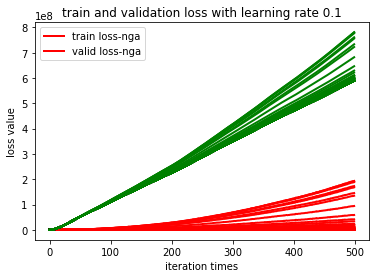

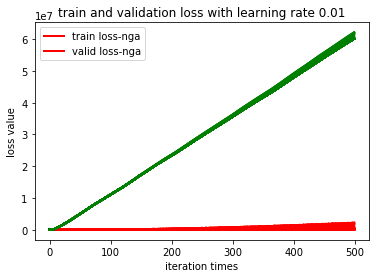

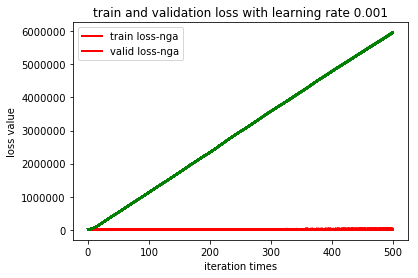

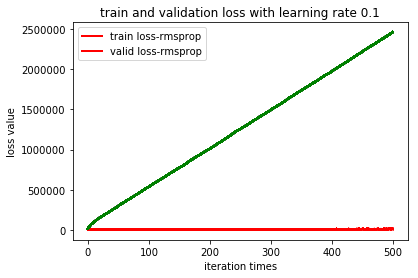

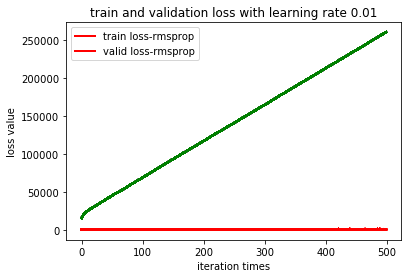

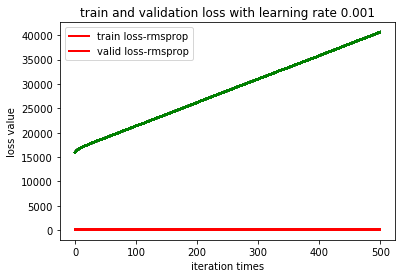

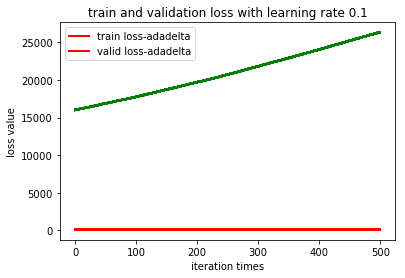

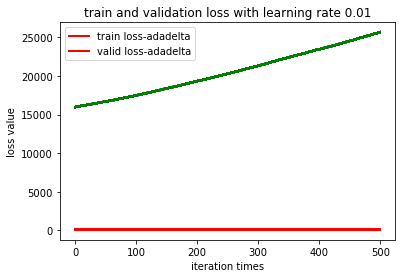

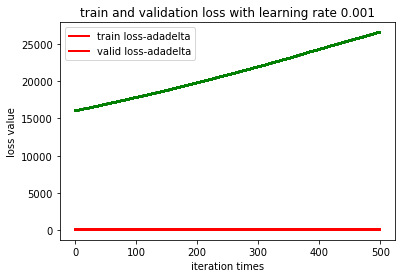

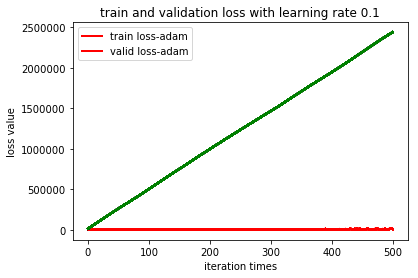

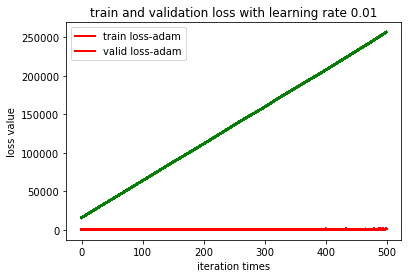

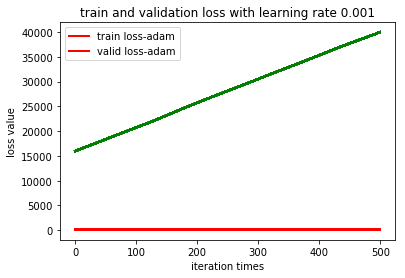

In [32]:
def plot_result(train_loss, valid_loss, fig_config):
    # train loss plt with different alpha
    for i in range(len(alpha)):
        plt.figure()
        plt.title('train and validation loss with learning rate '+ str(alpha[i]))
        plt.plot(range(len(train_loss[i])), train_loss[i], linewidth=2.0,
                 color=fig_config['color'][0], label=fig_config['label'][0])
        plt.plot(range(len(valid_loss[i])), valid_loss[i], linewidth=2.0,
                 color=fig_config['color'][1], label=fig_config['label'][1])
        plt.xlabel('iteration times')
        plt.ylabel('loss value')
        plt.legend(fig_config['label'])
        plt.show()


# plot params
fig_config = {    # train line
    'label':['train loss-nga', 'valid loss-nga'],     # validation line
    'color': ['r', 'g'],
}
plot_result(nga_total_train_loss, nga_total_valid_loss, fig_config)


# plot params
fig_config = {    # train line
    'label':['train loss-rmsprop', 'valid loss-rmsprop'],     # validation line
    'color': ['r', 'g'],
}
plot_result(rmsprop_total_train_loss, rmsprop_total_valid_loss, fig_config)


fig_config = {    # train line
    'label':['train loss-adadelta', 'valid loss-adadelta'],     # validation line
    'color': ['r', 'g'],
}
plot_result(adadelta_total_train_loss, adadelta_total_valid_loss, fig_config)


fig_config = {    # train line
    'label':['train loss-adam', 'valid loss-adam'],     # validation line
    'color': ['r', 'g'],
}
plot_result(adam_total_train_loss, adam_total_valid_loss, fig_config)